In [1]:
import numpy as np
from scipy.stats import norm
import random
import pandas as pd
from tqdm import tqdm  

# Define the number of politicians, dimensionality of the ideal points, and covariates
dim_ideal_points = 1
num_politicians = 1000
num_bills = 1000
doc_length = 300
vocab_size = 500
num_survey_questions = 100
num_covariates = 2
num_time_periods = 2

# Generate covariates for politicians, excluding the time covariate
covariates = np.random.randn(num_politicians, num_covariates)

# Define the coefficients for the covariates in the linear model for ideal points
coefficients = np.array([[0.5],
                         [0.3]])

# Generate initial ideal points for politicians based on covariates
initial_mean_ideal_points = np.dot(covariates, coefficients)
initial_cov_ideal_points = np.eye(dim_ideal_points) * 0.1  # Small variance around the mean
initial_ideal_points = []
for mean in initial_mean_ideal_points:
    initial_ideal_points.append(np.random.multivariate_normal(mean, initial_cov_ideal_points))
initial_ideal_points = np.array(initial_ideal_points)

# Function to update ideal points based on time and covariates
def update_ideal_points(initial_ideal_points, covariates, time_periods, time_effect=0.1):
    updated_ideal_points = []
    for t in range(time_periods):
        time_factor = t * time_effect  # Linear time effect
        new_ideal_points = initial_ideal_points + time_factor
        updated_ideal_points.append(new_ideal_points)
    return np.vstack(updated_ideal_points)

# Update ideal points for each time period
ideal_points = update_ideal_points(initial_ideal_points, covariates, num_time_periods)

# Function to generate speeches based on ideal points
def generate_speeches(ideal_points, doc_length, vocab_size, progress_bar=False):
    ideal_point_word_matrix = np.random.rand(ideal_points.shape[1], vocab_size)
    
    if progress_bar:
        iterator = tqdm(range(ideal_points.shape[0]))
    else:
        iterator = range(ideal_points.shape[0])
    documents = []
    for i in iterator:
        doc_ideal_points = ideal_points[i]
        doc_words = []
        word_probs = np.dot(doc_ideal_points, ideal_point_word_matrix)
        word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))
        for _ in range(doc_length):
            word_index = np.random.choice(vocab_size, p=word_probs)
            doc_words.append('word_' + str(word_index))
        doc_words = ' '.join(doc_words)
        documents.append(doc_words)
    return documents

# Function to generate voting behavior based on ideal points
def generate_voting(ideal_points, num_bills, progress_bar=False):
    votes = []
    if progress_bar:
        iterator = tqdm(range(num_bills))
    else:
        iterator = range(num_bills)
    for bill in iterator:
        bill_position = np.random.randn(dim_ideal_points)  # Position of the bill in the ideal point space
        vote_probs = norm.cdf(np.dot(ideal_points, bill_position))  # Probability of voting 'yes'
        votes.append(np.random.binomial(1, vote_probs))
    return np.array(votes).T

# Function to generate survey answers based on ideal points
def generate_survey_answers(ideal_points, num_survey_questions, progress_bar=False):
    survey_answers = []
    if progress_bar:
        iterator = tqdm(range(num_survey_questions))
    else:
        iterator = range(num_survey_questions)
    for survey in iterator:
        categories_per_survey = np.random.randint(2, 6)  # Random number of categories between 2 and 5
        survey_position = np.random.randn(dim_ideal_points, categories_per_survey)  # Position of each category in the ideal point space
        # Calculate the scores for each category
        scores = np.dot(ideal_points, survey_position)
        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Stability fix for softmax
        answer_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Select the category with the highest probability
        answers = [np.random.choice(categories_per_survey, p=answer_probs[i]) for i in range(ideal_points.shape[0])]
        survey_answers.append(answers)
    return np.array(survey_answers).T

# Generate speeches, voting behavior, and survey answers based on ideal points
speeches = generate_speeches(
    ideal_points,
    doc_length=doc_length,
    vocab_size=vocab_size,
    progress_bar=True
)
voting = generate_voting(
    ideal_points,
    num_bills=num_bills,
    progress_bar=True
)
survey_answers = generate_survey_answers(
    ideal_points,
    num_survey_questions=num_survey_questions,
    progress_bar=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.79it/s]


In [3]:
import numpy as np
import pandas as pd

# Assuming the following variables are already defined:
# speeches, num_politicians, num_bills, voting, survey_answers, num_survey_questions

time_covariate = np.tile(np.arange(num_time_periods), (num_politicians, 1)).T
time_covariate = time_covariate.flatten().reshape(-1, 1)

# Create initial DataFrame
data = pd.DataFrame({'doc_clean': speeches})
vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
vote_data = pd.DataFrame(voting, columns=vote_cols)
survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
data = pd.concat([data, vote_data, survey_data], axis=1)

data['cov0'] = np.hstack([covariates[:,0], covariates[:,0]])
data['cov1'] = np.hstack([covariates[:,1], covariates[:,1]])
data['t'] = time_covariate

# Ensure vote columns are of type float
data[vote_cols] = data[vote_cols].astype(float)

# Replace X% of the vote column cells with NaN
num_cells = data[vote_cols].size
num_nan = int(num_cells * 0.3)

# Get the flattened array of vote data
flat_vote_data = data[vote_cols].values.flatten()

# Randomly choose indices to replace with NaN
nan_indices = np.random.choice(num_cells, num_nan, replace=False)

# Replace the selected indices with NaN
flat_vote_data[nan_indices] = np.nan

# Reshape the flat array back to the original DataFrame
data[vote_cols] = flat_vote_data.reshape(data[vote_cols].shape)

#data = data.fillna(0)

# Print the DataFrame
print(data.head())

                                           doc_clean  vote_1  vote_2  vote_3  \
0  word_157 word_56 word_157 word_153 word_298 wo...     NaN     0.0     0.0   
1  word_52 word_478 word_134 word_146 word_449 wo...     1.0     1.0     1.0   
2  word_161 word_132 word_187 word_197 word_82 wo...     1.0     1.0     NaN   
3  word_147 word_312 word_434 word_92 word_73 wor...     NaN     NaN     NaN   
4  word_282 word_248 word_194 word_67 word_151 wo...     NaN     0.0     1.0   

   vote_4  vote_5  vote_6  vote_7  vote_8  vote_9  ...  Q_94  Q_95  Q_96  \
0     0.0     0.0     1.0     1.0     0.0     0.0  ...     1     2     0   
1     0.0     NaN     0.0     0.0     1.0     1.0  ...     1     2     1   
2     1.0     0.0     NaN     1.0     0.0     NaN  ...     3     0     1   
3     1.0     0.0     1.0     1.0     1.0     0.0  ...     2     0     0   
4     0.0     NaN     1.0     1.0     0.0     NaN  ...     3     1     1   

   Q_97  Q_98  Q_99  Q_100      cov0      cov1  t  
0     1   

In [4]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data_0 = IdealPointNNDataset(
    data,
    time_col = 't',
    time_value = 0,
    ideology = "~ cov0 + cov1 + C(t) - 1"
)
train_data_0.add_modality(
    modality = 'text',
    #content = '~ C(t)-1',
    df = data,
)
train_data_0.add_modality(
    modality = 'vote',
    df = data,
    columns = ['vote_{}'.format(i+1) for i in range(num_bills)]
)
train_data_0.add_modality(
    modality = 'discrete_choice',
    df = data,
    columns = ['Q_{}'.format(i+1) for i in range(num_survey_questions)]
)

/home/germain/Documents/neural_ideal_points/neural_ideal_point_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_data_1 = IdealPointNNDataset(
    data,
    time_col = 't',
    time_value = 1,
    ideology = "~ cov0 + cov1 + C(t) - 1"
)
train_data_1.add_modality(
    modality = 'text',
    #content = '~ C(t)-1',
    df = data,
)
train_data_1.add_modality(
    modality = 'vote',
    df = data,
    columns = ['vote_{}'.format(i+1) for i in range(num_bills)]
)
train_data_1.add_modality(
    modality = 'discrete_choice',
    df = data,
    columns = ['Q_{}'.format(i+1) for i in range(num_survey_questions)]
)

In [6]:
train_datasets = [train_data_0, train_data_1]

In [13]:
m = IdealPointNN(
    train_datasets, 
    n_dims=dim_ideal_points,
    update_prior=True,
    log_every_n_epochs = 1,
    dropout = 0,
    w_prior = 1,
    batch_size = 32,
    learning_rate=1e-3,
    #print_every_n_batches=10,
    patience=3
)


Epoch   1	Mean Training Loss:694.2337724


Epoch   2	Mean Training Loss:798.4076606


Epoch   3	Mean Training Loss:710.0256676


Epoch   4	Mean Training Loss:798.1326797


Early stopping at Epoch 4. Reverting to Epoch 1


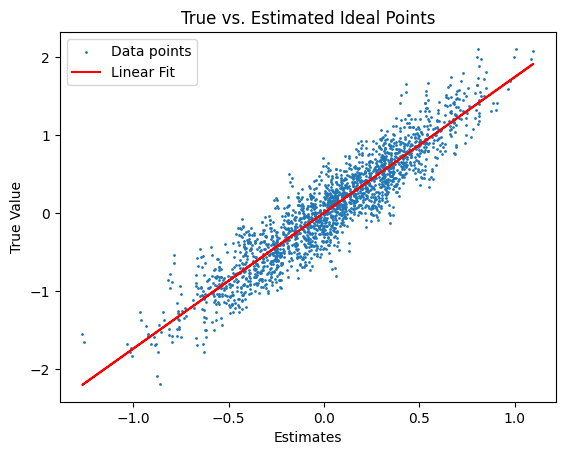

In [14]:
import numpy as np
import matplotlib.pyplot as plt

doc_dims = m.get_ideal_points(train_datasets)

x = doc_dims
y = ideal_points

plt.scatter(x, y, label='Data points', s=1)
coefficients = np.polyfit(x.flatten(), y.flatten(), 1)
fit = np.poly1d(coefficients)
plt.plot(x, fit(x), color='red', label='Linear Fit')
plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

In [15]:
print(np.corrcoef(x[:,0],y[:,0]))

[[1.         0.92555485]
 [0.92555485 1.        ]]


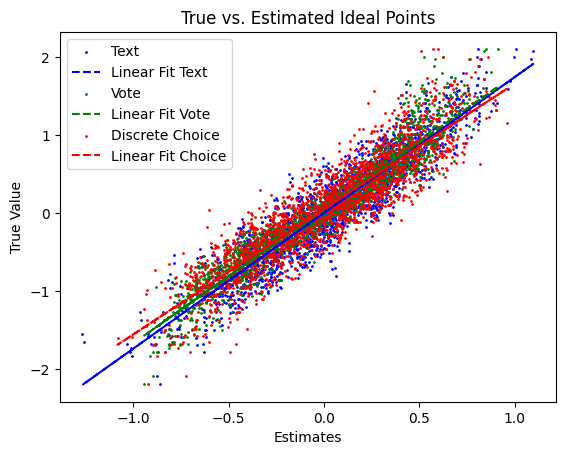

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x1 = m.get_ideal_points(train_datasets, modality='text')
x2 = m.get_ideal_points(train_datasets, modality='vote')
x3 = m.get_ideal_points(train_datasets, modality='discrete_choice')

# Plot the first set
plt.scatter(x1, y, label='Text', s=1, color='blue')
coefficients_1 = np.polyfit(x1.flatten(), y.flatten(), 1)
fit_1 = np.poly1d(coefficients_1)
plt.plot(x1, fit_1(x1), color='blue', linestyle='--', label='Linear Fit Text')

# Plot the second set
plt.scatter(x2, y, label='Vote', s=1, color='green')
coefficients_2 = np.polyfit(x2.flatten(), y.flatten(), 1)
fit_2 = np.poly1d(coefficients_2)
plt.plot(x2, fit_2(x2), color='green', linestyle='--', label='Linear Fit Vote')

# Plot the third set
plt.scatter(x3, y, label='Discrete Choice', s=1, color='red')
coefficients_3 = np.polyfit(x3.flatten(), y.flatten(), 1)
fit_3 = np.poly1d(coefficients_3)
plt.plot(x3, fit_3(x3), color='red', linestyle='--', label='Linear Fit Choice')

plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

In [17]:
print(np.corrcoef(x1[:,0],y[:,0]))
print(np.corrcoef(x2[:,0],y[:,0]))
print(np.corrcoef(x3[:,0],y[:,0]))

[[1.         0.92555485]
 [0.92555485 1.        ]]
[[1.         0.95849474]
 [0.95849474 1.        ]]
[[1.         0.90268814]
 [0.90268814 1.        ]]


In [18]:
print('Estimated lambda: {}'.format(m.prior.lambda_))
print('Estimated sigma: {}'.format(m.prior.sigma))

Estimated lambda: tensor([[0.1011],
        [0.0012],
        [0.0610],
        [0.0347]], device='cuda:0')
Estimated sigma: tensor([[0.0083]], device='cuda:0')
